In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
# ==========================================
# 2. ROBUST CONVERGENCE (Stability Check)
# ==========================================
def get_stability_round(df_sub, algo_name, threshold=0.01):
    """
    Finds the first round R where the range of loss (Max - Min) 
    for all subsequent rounds (R to End) is < threshold.
    This ensures the algorithm has actually settled.
    """
    # 1. Get mean loss curve
    algo_data = df_sub[df_sub['fl_algo'] == algo_name]
    if algo_data.empty: return None
    
    loss_series = algo_data.groupby('round')['global_logloss'].mean()
    rounds = loss_series.index
    
    # 2. Check Future Stability for each round
    for r in rounds:
        # Look ahead from current round to the end
        future_vals = loss_series.loc[r:]
        
        if len(future_vals) < 5: # Ignore the very end
            continue
            
        future_range = future_vals.max() - future_vals.min()
        
        # If the variations in the future are small enough, we found convergence
        if future_range < threshold:
            # Check if it's not "too late" (e.g., > 98% of rounds might just be the end)
            if r < (rounds.max() * 0.98):
                return r
    
    return None # Never stabilized

In [3]:
# ==========================================
# 3. JAIN'S VARIATION CALCULATION (SS / TotalSS)
# ==========================================
def calculate_variation_explained(data, metric_col):
    # 1. Aggregate Means (16 scenarios)
    group_cols = ['fl_algo', 'dataset_balance_type', 'failure_rate', 'iid']
    df_means = data.groupby(group_cols)[metric_col].mean().reset_index()

    # 2. Code Factors (-1, +1)
    df_means['A'] = df_means['fl_algo'].apply(lambda x: 1 if x == comparison_pair[1] else -1)
    df_means['B'] = df_means['dataset_balance_type'].apply(lambda x: 1 if x == 'balanced' else -1)
    df_means['C'] = df_means['failure_rate'].apply(lambda x: 1 if x > 0 else -1)
    df_means['D'] = df_means['iid'].apply(lambda x: 1 if x == 1 else -1)

    N = 16 
    factors_list = ['A', 'B', 'C', 'D']
    ss_values = {}
    SST_model = 0

    # 3. Calculate SS
    for r in range(1, 5):
        for combination in itertools.combinations(factors_list, r):
            col_name = "x" + "".join(combination)
            
            # Sign Column
            df_means[col_name] = 1
            for char in combination:
                df_means[col_name] *= df_means[char]
            
            # Contrast & Effect
            contrast = (df_means[col_name] * df_means[metric_col]).sum()
            ss = (contrast ** 2) / N
            
            # Label
            name_map = {'A': 'Algo', 'B': 'Data', 'C': 'Failure', 'D': 'IID'}
            readable_name = " : ".join([name_map[c] for c in combination])
            
            ss_values[readable_name] = ss
            SST_model += ss

    # 4. Percentages
    pct_variation = {k: (v / SST_model) * 100 for k, v in ss_values.items()}
    return pd.Series(pct_variation)

In [4]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
# Load your dataset
df = pd.read_csv('results/0_final_merged_global_with_comm.csv')

# --- TOURNAMENT CONFIGURATION ---
# Round 1:
#comparison_pair = ['FedAvg', 'FedAdagrad']
# Round 2: (Uncomment to run)
#comparison_pair = ['FedAdam', 'FedYogi']
# Final round: 
comparison_pair = ['FedAdagrad', 'FedAdam']

# Define metrics
metrics = {
    'Recall': 'global_recall_bin', 
    'ROC AUC': 'global_roc_auc', 
    'Specificity': 'global_specificity',
    'Loss': 'global_logloss'
}

# Consistent colors for all future plots
algo_colors = {
    'FedAvg': '#ff7f0e',      # Orange
    'FedAdagrad': '#1f77b4',  # Blue
    'FedAdam': '#d62728',     # Red
    'FedYogi': '#2ca02c'      # Green
}

# Filter data for the selected algorithms
df_subset = df[df['fl_algo'].isin(comparison_pair)].reset_index(drop=True).copy()
# Get Final Performance (Max round per seed) for Plots 1, 3, 4
max_round = df_subset['round'].max()
df_final = df_subset[df_subset['round'] == max_round].copy()

# 2. Get Average Performance (Mean of all rounds per experiment) -> For Stability/AUC Analysis
# We group by factors + seed (if it exists) to preserve variance for error bars.
# If 'seed' column is missing, this will just calculate the single mean per scenario.
group_cols = ['fl_algo', 'dataset_balance_type', 'failure_rate', 'iid']
if 'seed' in df_subset.columns:
    group_cols.append('seed')

df_totalavg = df_subset.groupby(group_cols)[list(metrics.values())].mean().reset_index()

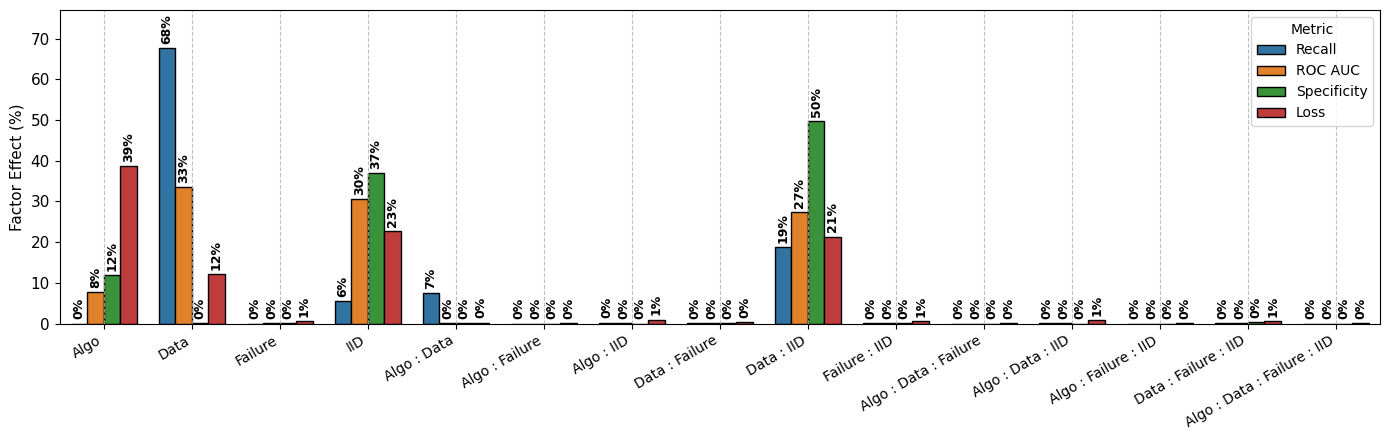

In [5]:
all_results = []
for metric_name, col in metrics.items():
    var_series = calculate_variation_explained(df_subset, col)
    temp_df = var_series.reset_index()
    temp_df.columns = ['Factor', 'Variation']
    temp_df['Metric'] = metric_name
    all_results.append(temp_df)

master_df = pd.concat(all_results, ignore_index=True)

# Define Standard Hierarchical Order
factors_list_code = ['A', 'B', 'C', 'D']
manual_order = []
for r in range(1, 5):
    for combination in itertools.combinations(factors_list_code, r):
        name_map = {'A': 'Algo', 'B': 'Data', 'C': 'Failure', 'D': 'IID'}
        readable_name = " : ".join([name_map[c] for c in combination])
        manual_order.append(readable_name)

# ==========================================
# 4. PLOT GENERATION (Final Version)
# ==========================================
plt.figure(figsize=(14, 4.5))

# Updated Custom Palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Vertical Grouped Bar Plot
ax = sns.barplot(
    data=master_df,
    x='Factor', 
    y='Variation', 
    hue='Metric', 
    order=manual_order, 
    palette=custom_palette, 
    edgecolor='black',
    width=0.75
)

# Styling
plt.ylabel('Factor Effect (%)', fontsize=11)
plt.xlabel('') # Removing the 'Factor' label

# Increase Y-limit to fit vertical text labels
plt.ylim(0, int(master_df['Variation'].max() * 1.15))

# Axis Ticks
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=11)

# Legend
plt.legend(title='Metric', title_fontsize='10', fontsize='10', loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.8)

# ADD LABELS ON TOP OF EACH BAR
for container in ax.containers:
    # We rotate labels 90 degrees to fit them without overlapping
    # We only label bars > 0.1% to keep it readable, or you can remove the "if" to show all.
    labels = [f'{v.get_height():.0f}%' if v.get_height() > 0.1 else '0%' for v in container]
    
    ax.bar_label(
        container, 
        labels=labels, 
        label_type='edge', 
        padding=3, 
        rotation=90, 
        fontsize=9, 
        fontweight='bold', 
        color='black'
    )

plt.tight_layout()
# Save as PNG (High Resolution)
plt.savefig(f'plots/effect_{comparison_pair[0]}_vs_{comparison_pair[1]}.png', dpi=300, bbox_inches='tight')
# Save as PDF (Vector Graphics - best for papers/LaTeX)
plt.savefig(f'plots/effect_{comparison_pair[0]}_vs_{comparison_pair[1]}.pdf', bbox_inches='tight')
plt.show()

In [6]:
# Calculate Points
convergence_points = {}
for algo in comparison_pair:
    conv_round = get_stability_round(df_subset, algo, threshold=0.05) # Threshold 0.02 tolerance
    if conv_round:
        convergence_points[algo] = conv_round

print(f"Stable Convergence Points Found: {convergence_points}")

Stable Convergence Points Found: {'FedAdagrad': 47, 'FedAdam': 32}


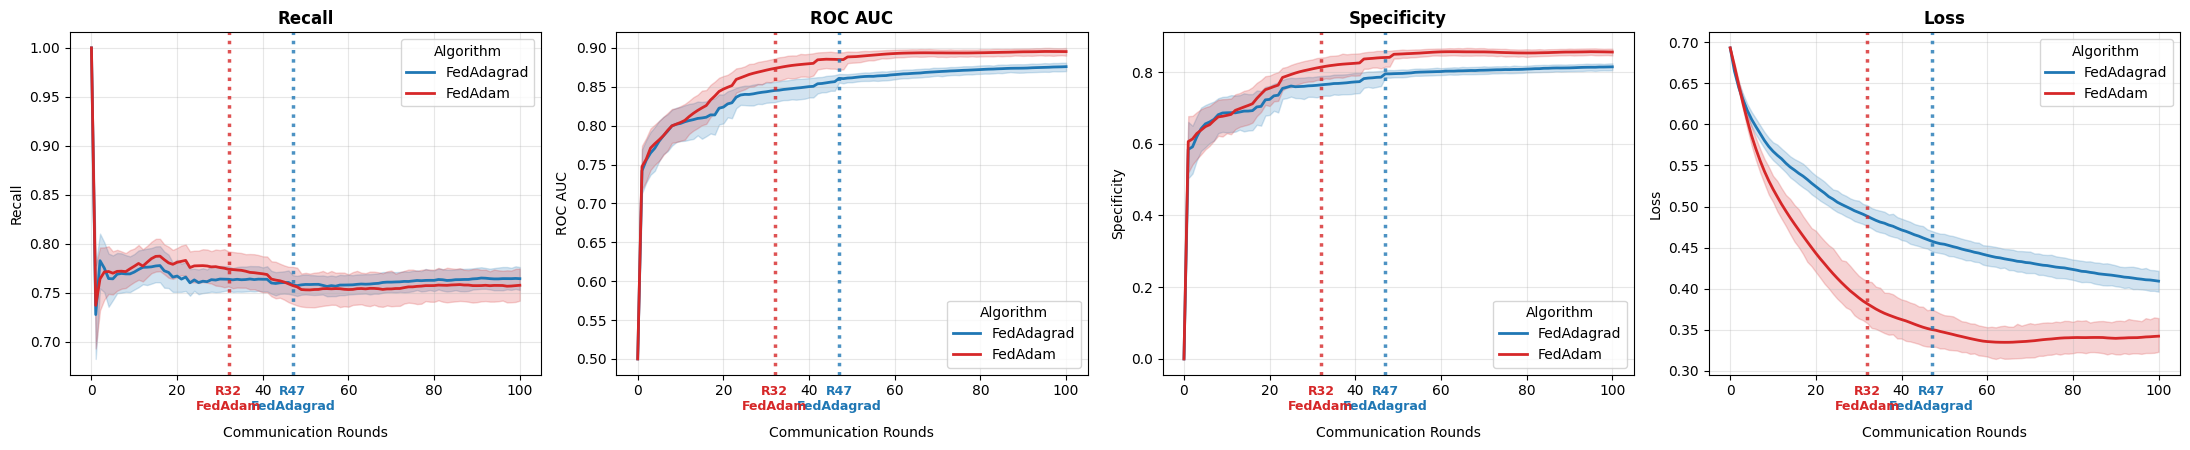

In [7]:
# ==========================================
# 3. PLOT 2: LEARNING CURVES
# ==========================================
fig2, axes2 = plt.subplots(1, 4, figsize=(22, 5)) # Increased height slightly for labels
axes2 = axes2.flatten()

for i, (name, col) in enumerate(metrics.items()):
    # Draw Lines
    sns.lineplot(
        data=df_subset, 
        x='round', 
        y=col, 
        hue='fl_algo', 
        ax=axes2[i], 
        palette=algo_colors, 
        linewidth=2,
        errorbar=("ci", 95)
    )
    
    # Draw Convergence Markers
    for algo, round_num in convergence_points.items():
        # Vertical Line inside plot
        axes2[i].axvline(
            x=round_num, 
            color=algo_colors[algo], 
            linestyle=':', 
            linewidth=2.5,
            alpha=0.8
        )
        
        # Text Label BELOW X-Axis
        # We use a blend transform: x is data coordinates, y is axes coordinates
        trans = axes2[i].get_xaxis_transform()
        
        axes2[i].text(
            round_num, -0.03, # y = -0.03 puts it below the ticks
            f'R{round_num}\n{algo}', 
            color=algo_colors[algo], 
            fontsize=9, 
            fontweight='bold',
            ha='center', 
            va='top',
            transform=trans
        )

    # Styling
    axes2[i].set_title(name, fontsize=12, fontweight='bold')
    # Add padding to x-label to make room for our custom text
    axes2[i].set_xlabel('Communication Rounds', labelpad=20) 
    axes2[i].set_ylabel(name)
    axes2[i].grid(True, alpha=0.3)
    axes2[i].legend(title='Algorithm', loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save as PNG (High Resolution)
plt.savefig(f'plots/rounds_{comparison_pair[0]}_vs_{comparison_pair[1]}.png', dpi=300, bbox_inches='tight')
# Save as PDF (Vector Graphics - best for papers/LaTeX)
plt.savefig(f'plots/rounds_{comparison_pair[0]}_vs_{comparison_pair[1]}.pdf', bbox_inches='tight')
plt.show()

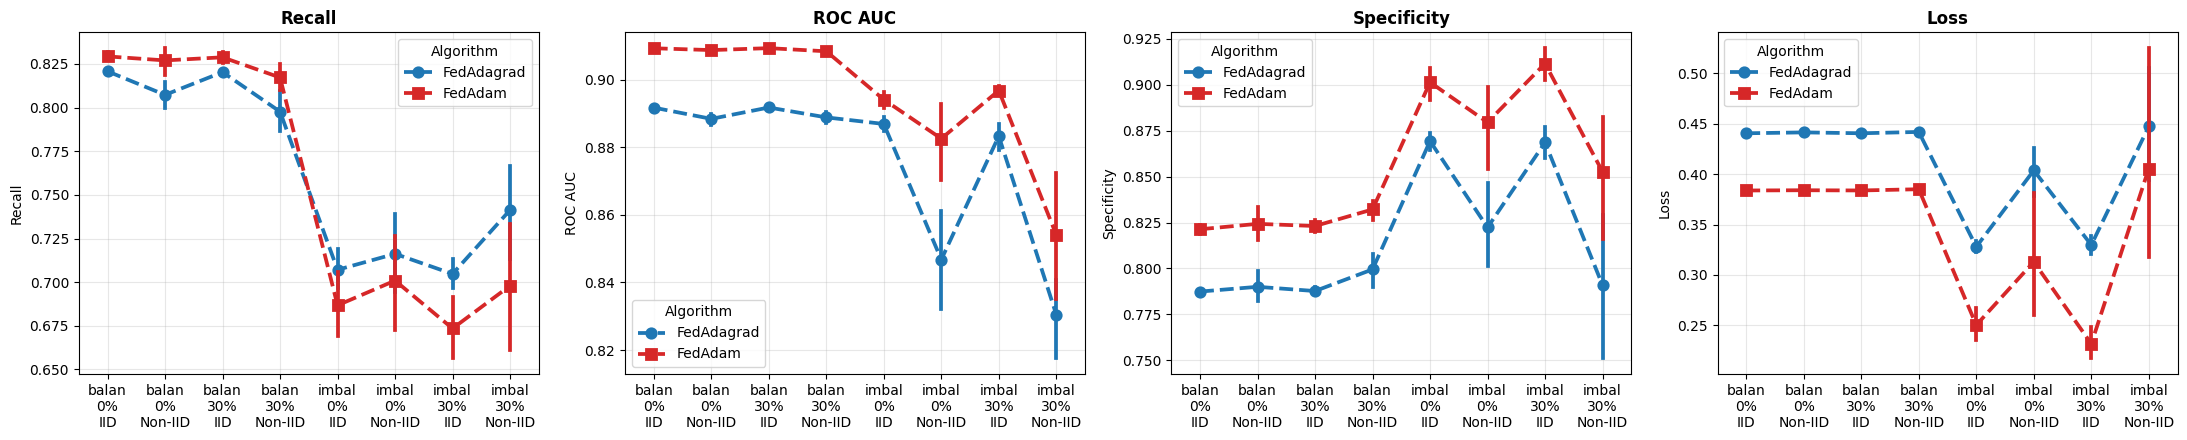

In [8]:
# cell 8
# ==========================================
# 6. PLOT 3: MULTI-METRIC SCENARIO STRESS TEST
# ==========================================
# 1. Prepare Data (Reuse logic from Plot 3)
#df_plot3 = df_subset.copy()
#df_plot3 = df_totalavg.copy()
df_plot3 = df_final.copy()

# Sort Scenarios (Soft -> Severe)
df_plot3 = df_plot3.sort_values(
    by=['dataset_balance_type', 'failure_rate', 'iid'], 
    ascending=[True, True, False] 
)

# Create Readable Labels
df_plot3['scenario'] = (
    df_plot3['dataset_balance_type'].replace({'balanced': 'balan', 'imbalanced': 'imbal'}) + '\n' +
    (df_plot3['failure_rate'] * 100).astype(int).astype(str) + '%\n' +
    df_plot3['iid'].apply(lambda x: 'IID' if x == 1 else 'Non-IID')
)

# 2. Plot Setup (1 Row, 4 Columns)
fig4, axes4 = plt.subplots(1, 4, figsize=(22, 4.5))
axes4 = axes4.flatten()

for i, (metric_name, col) in enumerate(metrics.items()):
    sns.pointplot(
        data=df_plot3, 
        x='scenario', 
        y=col, 
        hue='fl_algo', 
        ax=axes4[i],
        palette=algo_colors,
        markers=['o', 's', '^', 'D'],
        #dodge=0.1,          
        linestyles='--',    
        errorbar=('ci', 95)
    )
    
    # Styling
    axes4[i].set_title(metric_name, fontsize=12, fontweight='bold')
    axes4[i].set_xlabel('')
    axes4[i].set_ylabel(metric_name)
    axes4[i].grid(True, alpha=0.3)
    axes4[i].legend(title='Algorithm', loc='best')


plt.tight_layout()
# Save as PNG (High Resolution)
plt.savefig(f'plots/scenarios_{comparison_pair[0]}_vs_{comparison_pair[1]}.png', dpi=300, bbox_inches='tight')
# Save as PDF (Vector Graphics - best for papers/LaTeX)
plt.savefig(f'plots/scenarios_{comparison_pair[0]}_vs_{comparison_pair[1]}.pdf', bbox_inches='tight')
plt.show()

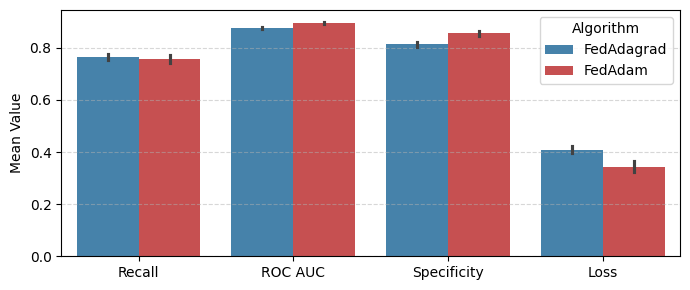

In [9]:
# cell 9
# ==========================================
# 7. PLOT 4: AGGREGATED BAR PLOTS (Mean ± SD)
# ==========================================
# 1. Prepare Data (Melt for Seaborn)
# We need to reshape the data so all metrics are in one column
#df_plot4 = df_subset.copy()
#df_plot4 = df_totalavg.copy()
df_plot4 = df_final.copy()

melted_final = df_plot4.melt(
    id_vars=['fl_algo'],
    value_vars=metrics.values(),
    var_name='Metric_Col',
    value_name='Value'
)

# Map the raw column names (e.g., 'global_logloss') back to readable names (e.g., 'Loss')
inv_map = {v: k for k, v in metrics.items()}
melted_final['Metric'] = melted_final['Metric_Col'].map(inv_map)

# 2. Plot
plt.figure(figsize=(7, 3))

sns.barplot(
    data=melted_final, 
    x='Metric', 
    y='Value', 
    hue='fl_algo', 
    palette=algo_colors, # <--- Correct Colors
    #errorbar='sd',       # Shows Standard Deviation across the 16 scenarios
    errorbar=('ci', 95),
    alpha=0.9
)

#plt.title('Average Final Performance (Across All Scenarios)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Value', fontsize=10) # <--- Updated Y Label
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Algorithm', loc='upper right')

plt.tight_layout()
# Save as PNG (High Resolution)
plt.savefig(f'plots/avg_final_{comparison_pair[0]}_vs_{comparison_pair[1]}.png', dpi=300, bbox_inches='tight')
# Save as PDF (Vector Graphics - best for papers/LaTeX)
plt.savefig(f'plots/avg_final_{comparison_pair[0]}_vs_{comparison_pair[1]}.pdf', bbox_inches='tight')
plt.show()